In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Semantic Segmentation <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/dinov2/blob/main/notebooks/semantic_segmentation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

INSTALL = False # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = "<FIXME>" # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

## Utilities

In [1]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_segmentor, inference_segmentor

import dinov2.eval.segmentation.models


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_segmenter(cfg, backbone_model):
    model = init_segmentor(cfg)
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

## Load pretrained backbone

In [2]:
BACKBONE_SIZE = "base" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

Using cache found in /home/ssw/.cache/torch/hub/facebookresearch_dinov2_main
/home/ssw/Python/Deep_learning/Seg_dinov2/DINOv2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ssw/Python/Deep_learning/Seg_dinov2/DINOv2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ssw/Python/Deep_learning/Seg_dinov2/DINOv2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## Load pretrained segmentation head

In [3]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_SCALE_COUNT = 3 # more scales: slower but better results, in (1,2,3,4,5)
HEAD_DATASET = "voc2012" # in ("ade20k", "voc2012")
HEAD_TYPE = "ms" # in ("ms, "linear")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")
if HEAD_TYPE == "ms":
    cfg.data.test.pipeline[1]["img_ratios"] = cfg.data.test.pipeline[1]["img_ratios"][:HEAD_SCALE_COUNT]
    print("scales:", cfg.data.test.pipeline[1]["img_ratios"])

model = create_segmenter(cfg, backbone_model=backbone_model)
load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.cuda()
model.eval()

/home/ssw/anaconda3/envs/dinov2/lib/python3.9/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2024-11-13 10:13:08,082 - mmcv - INFO - initialize BNHead with init_cfg {'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
2024-11-13 10:13:08,090 - mmcv - INFO - 
decode_head.conv_seg.weight - torch.Size([21, 3072, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2024-11-13 10:13:08,091 - mmcv - INFO - 
decode_head.conv_seg.bias - torch.Size([21]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2024-11-13 10:13:08,091 - mmcv - INFO - 
decode_head.bn.weight - torch.Size([3072]): 
The value is the same before and after calling `init_weights` of EncoderDecoder  
 
2024-11-13 10:13:08,091 - mmcv - INFO - 
decode_head.bn.bias - torch.Size([30

scales: [1.0, 1.32, 1.73]
load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_voc2012_ms_head.pth


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_voc2012_ms_head.pth" to /home/ssw/.cache/torch/hub/checkpoints/dinov2_vitb14_voc2012_ms_head.pth
100%|██████████| 862k/862k [00:03<00:00, 289kB/s] 


EncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): BNHead(
    input_transform=resize_concat, ignore_index=255, align_corners=False
    (loss_decode): CrossEntropyLoss(avg_non_ignore=False)
    (conv_seg): Conv2d(3072, 21, kernel_size=(1, 1), stride=(1, 1))
    (bn): SyncBatchNorm(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  init_cfg={'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
)

## Load sample image

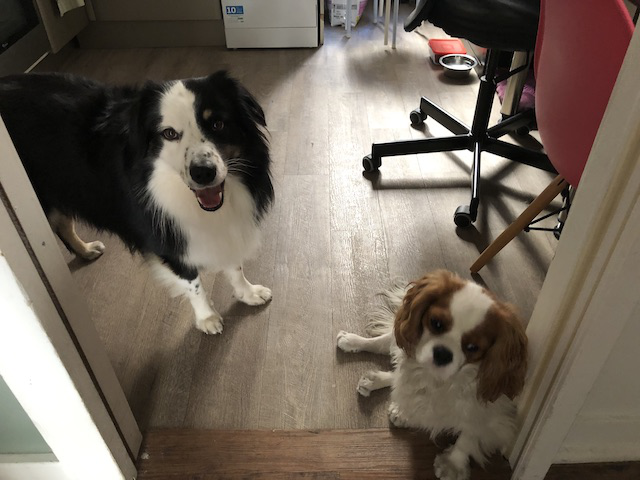

(640, 480)


In [11]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"


image = load_image_from_url(EXAMPLE_IMAGE_URL)
display(image)
print(image.size)

In [4]:
import torchvision
from torchvision.datasets import Cityscapes
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
import random

# 数据集路径
root_dir = "cityscapes"

# 数据转换
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
target_transform = T.ToTensor()
dataset = []
for i,det in enumerate(["train","val","test"]):
    # 加载 Cityscapes 数据集
    dataset.append(Cityscapes(
        root=root_dir,
        split=det,
        mode="fine",
        target_type="semantic",
        transform=transform,
        target_transform=target_transform
    ))

# 获取 1/4 的索引
subset_size = len(dataset[0]) // 64
subset_indices = random.sample(range(len(dataset[0])), subset_size)

# 创建一个 SubsetRandomSampler，传入上述索引
sampler = SubsetRandomSampler(subset_indices)

train_loader = DataLoader(dataset[0], batch_size=4, shuffle=True)
# train_loader = DataLoader(dataset[0], batch_size=4, sampler=sampler)
val_loader = DataLoader(dataset[1], batch_size=4, shuffle=True)

# # 获取 1/4 的索引
# subset_size2 = len(dataset[2]) // 64
# subset_indices2 = random.sample(range(len(dataset[2])), subset_size2)
#
# # 创建一个 SubsetRandomSampler，传入上述索引
# sampler2 = SubsetRandomSampler(subset_indices2)

test_loader = DataLoader(dataset[2], batch_size=4, shuffle=True)

## Semantic segmentation on sample image

torch.Size([224, 224, 3])


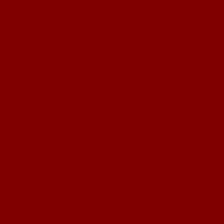

In [6]:
import numpy as np
from PIL import Image
import dinov2.eval.segmentation.utils.colormaps as colormaps

images, labels = next(iter(val_loader))
DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}


def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)


array = np.array(images[0].permute(1, 2, 0))[:, :, ::-1] # BGR
print(images[0].permute(1, 2, 0).shape)
segmentation_logits = inference_segmentor(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, HEAD_DATASET)
display(segmented_image)

## Load pretrained segmentation model (Mask2Former)

In [7]:
import dinov2.eval.segmentation_m2f.models.segmentors

CONFIG_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f_config.py"
CHECKPOINT_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth"

cfg_str = load_config_from_url(CONFIG_URL)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

model = init_segmentor(cfg)
load_checkpoint(model, CHECKPOINT_URL, map_location="cpu")
model.cuda()
model.eval()

/home/ssw/Python/Deep_learning/Seg_dinov2/DINOv2/dinov2/eval/segmentation_m2f/models/losses/cross_entropy_loss.py:222: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/home/ssw/anaconda3/envs/dinov2/lib/python3.9/site-packages/mmcv/ops/multi_scale_deform_attn.py:216: UserWarning: You'd better set embed_dims in MultiScaleDeformAttention to make the dimension of each attention head a power of 2 which is more efficient in our CUDA implementation.
  warnings.warn(


load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth


EncoderDecoderMask2Former(
  (backbone): ViTAdapter(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1536, out_features=4608, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1536, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (mlp): SwiGLUFFN(
          (w1): Linear(in_features=1536, out_features=4096, bias=True)
          (w2): Linear(in_features=1536, out_features=4096, bias=True)
          (w3): Linear(in_features=4096, out_features=1536, bias=True)
        )
      )
     

## Semantic segmentation on sample image

(640, 480, 3) torch.Size([4, 1, 1024, 2048])
(640, 480, 3) torch.Size([4, 1, 1024, 2048])
(640, 480, 3) torch.Size([4, 1, 1024, 2048])
(640, 480, 3) torch.Size([4, 1, 1024, 2048])


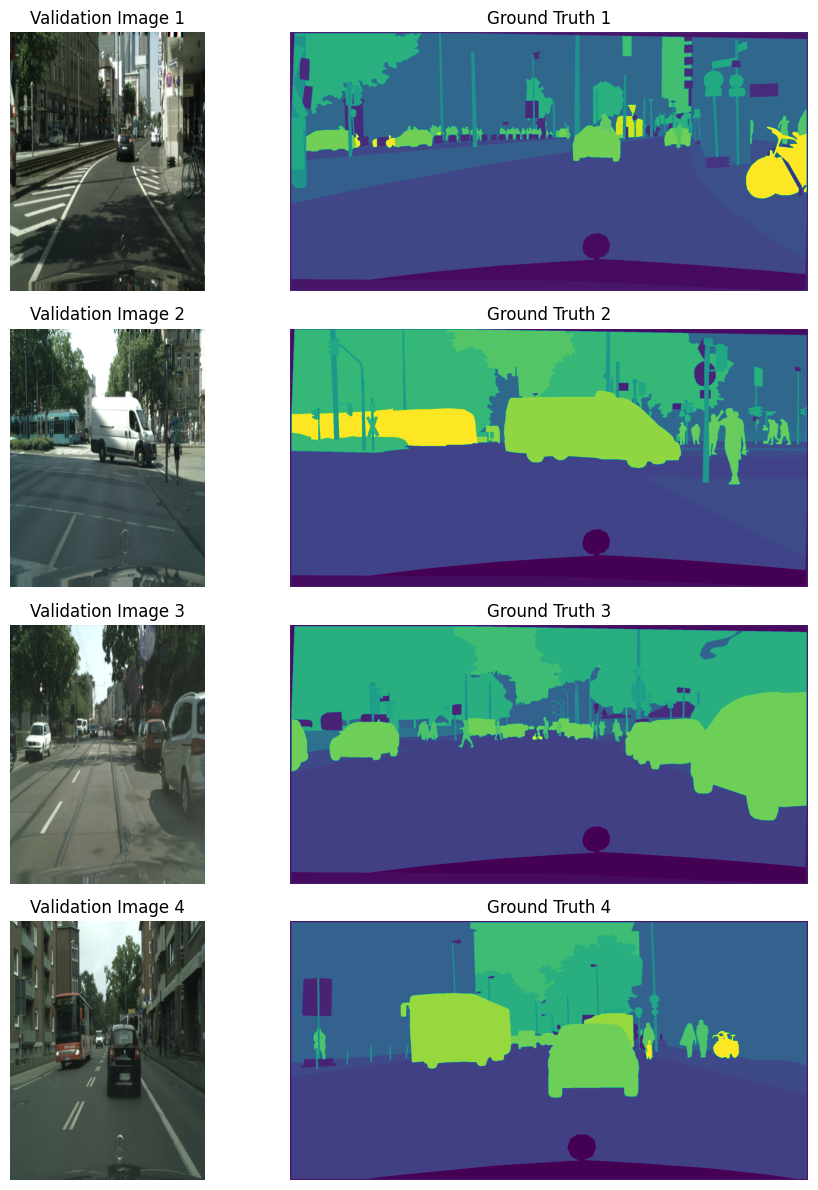

In [41]:
# 可视化真实分割标签
def visualize_segmentation(images, labels, num_images=4):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    for i in range(num_images):
        # 显示原始图像
        img = images[i].permute(1, 2, 0)  # 将通道从 (C, H, W) 转为 (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # 去标准化
        img = img.numpy().clip(0, 1)

        print(img.shape,labels.shape)
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Validation Image {i+1}")
        axes[i, 0].axis("off")

        # 显示真实标签
        label = labels[i].squeeze().numpy()
        axes[i, 1].imshow(label, cmap="viridis")
        axes[i, 1].set_title(f"Ground Truth {i+1}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# 调用可视化函数
visualize_segmentation(images, labels)

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

# 通用评估函数
def evaluate(model, loader, criterion, device, phase="validation", num_classes=21):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions, targets_list, images_list = [], [], []

    with torch.no_grad():
        progress_bar = tqdm(loader, desc=f"{phase.capitalize()} Phase", leave=False, dynamic_ncols=True)
        for images, targets in progress_bar:
            images, targets = images.to(device), targets.squeeze(1).to(device)
            targets = (targets * (num_classes - 1)).long()

            array = np.array(images.permute(1, 2, 0))[:, :, ::-1] # BGR
            segmentation_logits = inference_segmentor(model, array)[0]
            segmented_image = render_segmentation(segmentation_logits, "ade20k")
            # outputs = model(images)
            loss = criterion(segmented_image, targets)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.numel()

            # 保存推理结果、标签和原始图像
            predictions.append(predicted.cpu().numpy())
            targets_list.append(targets.cpu().numpy())
            images_list.append(images)

    avg_loss = running_loss / len(loader.dataset)
    accuracy = 100 * correct / total
    print(f"{phase.capitalize()} Loss: {avg_loss:.4f}, {phase.capitalize()} Accuracy: {accuracy:.2f}%")

    # 可视化
    visualize_predictions(images_list, predictions, targets_list, phase)
    return avg_loss, accuracy

# 可视化函数
def visualize_predictions(images, predictions, targets, phase):
    num_images = 4  # 设置可视化的图像数量
    fig, axes = plt.subplots(num_images, 2 , figsize=(10, num_images * 3))

    for i in range(num_images):
        # 绘制原始图像
        if phase == "test":
            target_size = [1024,2048]
            img = images[i][0].permute(1, 2, 0).cpu()  # 将通道从 (C, H, W) 转为 (H, W, C)
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # 去标准化
            img = F.resize(img.permute(2, 0, 1).unsqueeze(0), target_size)  # 转为 (1, C, H, W)
            img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # 转回 (H, W, C)

            # img = img.cpu().numpy().clip(0, 1)

            axes[i,0].imshow(img)
            axes[i,0].set_title(f"{phase.capitalize()} Image {i+1}")
            axes[i,0].axis("off")

            # 绘制预测结果
            axes[i,1].imshow(predictions[i][0], cmap="viridis", alpha=0.6)
            axes[i,1].set_title(f"{phase.capitalize()} Prediction {i+1}")
            axes[i,1].axis("off")

        elif phase == "validation":
            # 绘制原始图像和预测
            axes[i, 0].imshow(predictions[i][0], cmap="viridis")
            axes[i, 0].set_title(f"{phase.capitalize()} Prediction {i+1}")
            axes[i, 0].axis("off")

            # 绘制真实标签
            axes[i, 1].imshow(targets[i][0], cmap="viridis")
            axes[i, 1].set_title(f"{phase.capitalize()} Target {i+1}")
            axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

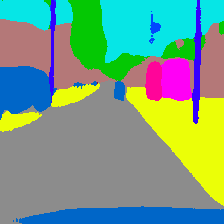

TypeError: forward() missing 1 required positional argument: 'img_metas'

In [12]:
from torch import nn
array = np.array(images[3].permute(1, 2, 0))[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, "ade20k")

display(segmented_image)
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失
evaluate(model, val_loader, criterion, device='cuda', phase="validation",num_classes=21)